In [1]:
import os
import platform
import pandas as pd
import numpy as np
import matplotlib
import seaborn as sns
import matplotlib.pyplot as plt

# Check which platform is running the notebook
if platform.system() == 'Windows':
    PROJECT_PATH = "\\".join(os.getcwd().split('\\')[:-1])
else:
    # Assuming a Unix based platform
    PROJECT_PATH = "/".join(os.getcwd().split('/')[:-1])

DATA_PATH = os.path.join(PROJECT_PATH, 'data')
TRAIN_DATA_PATH = os.path.join(DATA_PATH, 'train.csv')

train_data = pd.read_csv(TRAIN_DATA_PATH)
train_data.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


## Training & Testing Sets

In [2]:
from sklearn.model_selection import train_test_split

RANDOM_STATE = 42
target_label = 'SalePrice'

X = train_data.drop(target_label, axis=1)
y = train_data[target_label]

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=RANDOM_STATE, test_size=0.3)
print('Train Size: ', X_train.shape)
print('Test Size: ', X_test.shape)

Train Size:  (1022, 80)
Test Size:  (438, 80)


In [3]:
# Create a copy to manipulate
X_train_df = X_train.copy()
X_train_df = X_train_df.drop('Id', axis=1)

In [4]:
from utils.core import *

X_train_df = remove_missing_features(X_train_df, verbose=True)

Alley         93.542%
PoolQC        99.511%
Fence         80.235%
MiscFeature   96.086%


## Numeric Features

In [5]:
numeric_features = X_train_df.select_dtypes(['int64', 'float64'])
numeric_cols = numeric_features.columns.tolist()
numeric_features.shape

(1022, 36)

In [9]:
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import MinMaxScaler
from sklearn.pipeline import Pipeline

numeric_pipeline = ColumnTransformer([
    ('process', Pipeline([
        ('impute', SimpleImputer(strategy='median')),
        ('scaler', MinMaxScaler())
    ]), numeric_cols)
])

In [10]:
from sklearn.ensemble import RandomForestRegressor

numeric_training = numeric_pipeline.fit_transform(numeric_features)

rand_forest = RandomForestRegressor(random_state=RANDOM_STATE)
scores = cross_val_regression(rand_forest, numeric_training, y_train)
print('Numeric Random Forest RMSE: {:.6f}'.format(scores['rmse']))
print('Numeric Random Forest RMSLE: {:6f}'.format(scores['rmlse']))

Numeric Random Forest RMSE: 31600.591887
Numeric Random Forest RMSLE: 0.153450


In [30]:
from sklearn.preprocessing import StandardScaler, MinMaxScaler, FunctionTransformer

class Scalers(object):
    @staticmethod
    def standard_scaler(data):
        scaler = StandardScaler()
        return scaler.fit_transform(data)
    
    @staticmethod
    def min_max_scaler(data):
        scaler = MinMaxScaler()
        return scaler.fit_transform(data)
    
    @staticmethod
    def log_scaler(data):
        scaler = FunctionTransformer(np.log1p)
        return scaler.fit_transform(data)
    
    def apply_scalers(data):
        return {
            'standard': Scalers.standard_scaler(data),
            'min_max': Scalers.min_max_scaler(data),
            'log': Scalers.log_scaler(data)
        }

In [40]:
from sklearn.feature_selection import SelectKBest, f_regression

k_best_numeric = SelectKBest(score_func=f_regression, k=15)
k_best_numeric_data = k_best_numeric.fit_transform(numeric_training, y_train)

In [42]:
scores = cross_val_regression(rand_forest, k_best_numeric_data, y_train)
print('Numeric Random Forest k=15 RMSE: {:.6f}'.format(scores['rmse']))
print('Numeric Random Forest k=15 RMSLE: {:6f}'.format(scores['rmlse']))

Numeric Random Forest k=15 RMSE: 31748.538837
Numeric Random Forest k=15 RMSLE: 0.157814


From choosing the best 15 features, the performance of the model has slighly decreased. Trying PCA on the all the numeric values to see if the same scores are maintained

In [47]:
from sklearn.decomposition import PCA

pca = PCA(random_state=42, n_components=0.99)
pca_numeric = pca.fit_transform(numeric_training)

In [48]:
scores = cross_val_regression(rand_forest, pca_numeric, y_train)
print('Numeric Random Forest PCA RMSE: {:.6f}'.format(scores['rmse']))
print('Numeric Random Forest PCA RMSLE: {:6f}'.format(scores['rmlse']))

Numeric Random Forest PCA RMSE: 36132.672838
Numeric Random Forest PCA RMSLE: 0.170683


Try sampling the outliers to see if that improves overall accuracy

In [114]:
from sklearn.utils import resample

q1, q3 = y_train.quantile([0.25, 0.75])
iqr = q3 - q1
max_outliers = q3 + 1.5 * iqr

y_outliers = y_train[y_train > max_outliers]
X_outliers = numeric_features.loc[y_outliers.index]

n_samples = 500
X_resampled = resample(X_outliers, random_state=RANDOM_STATE, n_samples=n_samples)
y_resampled = resample(y_outliers, random_state=RANDOM_STATE, n_samples=n_samples)

In [115]:
X_sampled = pd.concat([numeric_features, X_resampled])
y_sampled = pd.concat([y_train, y_resampled])

In [116]:
X_sampled = X_sampled.reset_index(drop=True)
y_sampled = y_sampled.reset_index(drop=True)

In [117]:
X_sampled_processed = numeric_pipeline.transform(X_sampled)

In [118]:
scores = cross_val_regression(rand_forest, X_sampled_processed, y_sampled)
print('Numeric Random Forest Resampled Outliers RMSE: {:.6f}'.format(scores['rmse']))
print('Numeric Random Forest Resampled Outliers RMSLE: {:6f}'.format(scores['rmlse']))

Numeric Random Forest Resampled Outliers RMSE: 33332.978522
Numeric Random Forest Resampled Outliers RMSLE: 0.136032


From resampling the outliers, we have managed to improve the overall result of the model when looking at the numeric features.

## Categorical Features

In [119]:
# Define the ordinal features
ordinal_cols = [
    'LotShape',
    'ExterQual',
    'ExterCond',
    'BsmtQual',
    'BsmtCond',
    'BsmtExposure',
    'BsmtFinType1',
    'BsmtFinType2',
    'HeatingQC',
    'KitchenQual',
    'FireplaceQu',
    'GarageQual',
    'GarageCond',
]

object_features = X_train_df.select_dtypes(['object'])
object_cols = object_features.columns

categorical_cols = ~object_cols.isin(ordinal_cols)

## Experiment - Scaling the target feature

Try scaling the target feature to see if that can improve the distribution of the data as well as improve the overall accuracy of the model

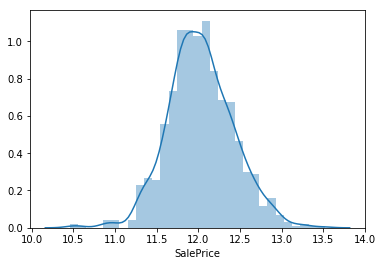

In [132]:
y_train_log = np.log1p(y_train)

sns.distplot(np.log1p(y_train))
plt.show()

In [126]:
scores = cross_val_regression(rand_forest, numeric_training, y_train_log)
print('Numeric Random Forest Resampled Outliers RMSE: {:.6f}'.format(scores['rmse']))
print('Numeric Random Forest Resampled Outliers RMSLE: {:6f}'.format(scores['rmlse']))

Numeric Random Forest Resampled Outliers RMSE: 0.151963
Numeric Random Forest Resampled Outliers RMSLE: 0.011731


Seems to perform fairly well but would need to experiment with returning the actual result to ensure it is working correclly.

### Creating a simple random forest model

In [139]:
rand_forest_v1 = RandomForestRegressor(random_state=RANDOM_STATE)
rand_forest_v1.fit(numeric_training, y_train_log)

RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=None, max_features='auto', max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      n_estimators=100, n_jobs=None, oob_score=False,
                      random_state=42, verbose=0, warm_start=False)

In [140]:
y_pred = rand_forest_v1.predict(numeric_training)
y_pred = np.exp(y_pred) - 1
print(y_pred)

[167309.95703817 143432.13756843 206152.50111663 ... 118086.72391505
 177296.753079   180446.29929771]


In [141]:
root_mean_squared_error(y_train, y_pred)

13047.920536507903

In [142]:
root_mean_log_error(y_train, y_pred)

0.056474456859730224

Seems to be rather promosing and has show far yeidled the smallest error rate when scaled back. Next I will try and create a simple pipeline to see if it can automatically scale it back

In [154]:
from sklearn.base import RegressorMixin

class RandomForestRegressorAdapter(RegressorMixin):
    def __init__(self, **kwargs):
        self.forest = RandomForestRegressor(**kwargs)
    
    def fit(self, X, y):
        y = np.log1p(y)
        self.forest = self.forest.fit(X, y)
        return self
    
    def predict(self, X):
        y_pred = self.forest.predict(X)
        return np.exp(y_pred) - 1
    
    def get_params(self, **kwargs):
        return self.forest.get_params(**kwargs)

In [155]:
r = RandomForestRegressorAdapter(random_state=RANDOM_STATE)
scores = cross_val_regression(r, numeric_training, y_train)
print('Numeric Random Forest Resampled Outliers RMSE: {:.6f}'.format(scores['rmse']))
print('Numeric Random Forest Resampled Outliers RMSLE: {:6f}'.format(scores['rmlse']))

Numeric Random Forest Resampled Outliers RMSE: 32222.193085
Numeric Random Forest Resampled Outliers RMSLE: 0.151963
